## Imports

In [503]:
#import basic modules
import pandas as pd 
import numpy as np
import seaborn as sb
import warnings
import matplotlib.pyplot as plt        
%matplotlib inline

from sklearn import preprocessing

#import feature selection modules
from sklearn.feature_selection import mutual_info_classif,RFE,RFECV

#import classification modules
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier

from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

from sklearn.neural_network import MLPClassifier

#import classification evaluation
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold 
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve 
from sklearn.metrics import f1_score
from sklearn.metrics import auc

In [504]:
#warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings(action='ignore')
sb.set(color_codes=True, font_scale=1.2)

## Load Data

In [505]:
def load_data(file_name):
    def readcsv(file_name):
        return pd.read_csv(file_name)
    def readexcel(file_name):
        return pd.read_excel(file_name)
    def readjson(file_name):
        return pd.read_json(file_name)
    func_map = {
        "csv": readcsv,
        "xls": readexcel,
        "xlsx": readexcel,
        "txt": readcsv,
        "json": readjson
    }
    
    # default reader = readcsv
    reader = func_map.get("csv")
    
    for k,v in func_map.items():
        if file_name.endswith(k):
            reader = v
            break
    return reader(file_name)

## Data Cleanup

In [529]:
#data cleaning function
def cleaningup(df, to_date=[], to_numeric=[], cols_to_delete=[], fill_na_map={}, cols_to_drop_na_rows=[]):
    """
    We will perform all the generic cleanup stuff in this function,
    Data specific stuff should be handled by driver program.
    
    Mandatory Parameter:
    df :            Dataframe to be cleaned
    
    Optional Parameters:
    to_date:        List of columns that are suppossed to contain date
    to_numeric:     List of columns that are suppossed to be numeric
    cols_to_delete: All the useless columns that we need to delete from our dataset
    fill_na_map:    A dictionary containing map for column and a value to be filled in missing places
                    e.g. {'age': df['age'].median(), 'city': 'Karachi'}
    cols_to_drop_na_rows: List of columns where missing value in not tolerable and we couldn't risk predicting value for it,
                          so we drop such rows.
    """
    def change_type_to_date(df, to_date):
        # Deal with incorrect data in date column
        for i in to_date:
            df[i] = pd.to_datetime(df[i], errors='coerce')
        return df
            
    def change_type_to_numeric(df, to_numeric):
        # Deal with incorrect data in numeric columns
        for i in to_numeric:
            df[i] = pd.to_numeric(df[i], errors='coerce')
        return df
    
    def drop_useless_colums(df, cols_to_delete):
        # Drop useless columns before dealing with missing values
        for i in cols_to_delete:
            df = df.drop(i, axis=1)
        return df
            
    def drop_useless_rows(df):
        # Drop useless rows before dealing with missing values
        # Delete all rows containing 40% or more missing data
        min_threshold = math.ceil(len(df.columns)*0.4)
        df = df.dropna(thresh=min_threshold)
        return df
    
    def drop_na_rows(df, cols_to_drop_na_rows):
        # Drop rows with missing values for the columns specifically provided by the driver program
        for i in cols_to_drop_na_rows:
            df = df.drop(df[df[i].isnull()].index)
        return df
    
    def fill_na_vals(df, fill_na_map):
        # Deal with missing values
        for col,val in fill_na_map.items():
            df[col].fillna(val, inplace=True)
        return df
    
    try:
        df = change_type_to_date(df, to_date)
        df = change_type_to_numeric(df, to_numeric)
        df = drop_useless_colums(df, cols_to_delete)
        df = drop_useless_rows(df)
        df = drop_na_rows(df, cols_to_drop_na_rows)
        df = fill_na_vals(df, fill_na_map)
        print("df is all cleaned up..")
        return df
    except Exception as e:
        print("Failed to perform cleanup, exception=%s" % str(e))
    finally:
        return df

## Data Analysis

Perform basic analysis to get familiar with data in hand

In [507]:
#basic analysis
def basicanalysis(df):
    print("Shape is:\n", df.shape)
    print("Columns are:\n", df.columns)
    print("Types are:\n", df.dtypes)
    print("Statistical Analysis of Numerical Columns:\n", df.describe())

Perform basic analysis over categorical columns

In [508]:
#string column analysis analysis
def stringcolanalysis(df):
    stringcols = df.select_dtypes(exclude=np.number)
    fig = plt.figure(figsize = (8,10))
    for i,col in enumerate(stringcols):
        fig.add_subplot(4,2,i+1)
        fig.savefig('Categorical.png')
        df[col].value_counts().plot(kind = 'bar', color='black' ,fontsize=10)
        plt.tight_layout()
        plt.title(col)

Perform basic analysis over numerical columns

In [509]:
#numerical analysis
#histograms and boxplots for all numerical columns
def numcolanalysis(df):
    numcols = df.select_dtypes(include=np.number)
    
    # Box plot for numerical columns
    for col in numcols:
        fig = plt.figure(figsize = (5,5))
        sb.boxplot(df[col], color='grey', linewidth=1)
        plt.tight_layout()
        plt.title(col)
        plt.savefig("Numerical.png")
    
    # Lets also plot histograms for these numerical columns
    df.hist(column=list(numcols.columns),bins=25, grid=False, figsize=(15,12),
                 color='#86bf91', zorder=2, rwidth=0.9)


Perform basic correlation analysis

In [510]:
# Helper function to perform correlation analysis over numerical columns
def correlation_anlysis(df):
    # NOTE: If label column is non numeric, we need to 'encode' it before calling this function to have a better visibility
    numcols = df.select_dtypes(include=np.number)
    corr = numcols.corr()
    ax = sb.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sb.diverging_palette(20, 220, n=200),
    square=True
    )
    
    ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right')


## Encoding

Apply label encoding on specified columns

In [511]:
def apply_label_encoding(df, cols=[]):
    le = preprocessing.LabelEncoder()
    for i in cols:
        le.fit(df[i])
        #print(list(le.classes_))
        df[i] = le.transform(df[i])
    return df

One-Hot encoding on specified columns

In [512]:
def stringcolencoding(df, cols=[]):
    label_encoder = preprocessing.LabelEncoder()
    onehot_encoder = preprocessing.OneHotEncoder(sparse=False)
    for col in cols:
        integer_encoded = label_encoder.fit_transform(df[col])
        ohe = onehot_encoder.fit_transform(integer_encoded.reshape(-1,1))
        dfOneHot = pd.DataFrame(ohe, columns = [col+"_"+str(int(i)) for i in range(ohe.shape[1])])
        df = pd.concat([df, dfOneHot], axis=1)
        df = df.drop(col, axis=1)


## Train Test Split

In [530]:
#splitting manually
def traintestsplit(df,split,random=None, label_col=''):
    #make a copy of the label column and store in y
    y = df[label_col].copy()
    #now delete the original
    X = df.drop(label_col,axis=1)
    #manual split
    trainX, testX, trainY, testY= train_test_split(X, y, test_size=split, random_state=random)
    return X, trainX, testX, trainY, testY


In [531]:
def XYsplit(df, label_col):
    y = df[label_col].copy()
    X = df.drop(label_col,axis=1)
    return X,y

#### For Cross Validation, lets create generator functions for different cross validation techniques, this will help us run an iterator over all folds

In [532]:
def cross_valid_kfold(X, y, split=4, random=None, shuffle=False):
    """
    Generator function for KFold cross validation
    """
    kf = KFold(n_splits=split, random_state=random, shuffle=shuffle)
    for train_index, test_index in kf.split(X):
        trainX, testX = X.iloc[train_index], X.iloc[test_index] 
        trainY, testY = y.iloc[train_index], y.iloc[test_index]
        yield trainX,trainY,testX,testY
    

def cross_valid_repeated_kf(X, y, split=4, random=None, repeat=10):
    """
    Generator function for Repeated KFold cross validation
    """
    kf = RepeatedKFold(n_splits=split, random_state=random, n_repeats=repeat)
    for train_index, test_index in kf.split(X):
        trainX, testX = X.iloc[train_index], X.iloc[test_index] 
        trainY, testY = y.iloc[train_index], y.iloc[test_index]
        yield trainX,trainY,testX,testY
        

def cross_valid_stratified_kf(X, y, split=4, random=None, shuffle=False):
    """
    Generator function for Stratified KFold cross validation
    """
    skf = StratifiedKFold(n_splits=split, random_state=random, shuffle=shuffle)
    for train_index, test_index in skf.split(X, y):
        trainX, testX = X.iloc[train_index], X.iloc[test_index] 
        trainY, testY = y.iloc[train_index], y.iloc[test_index]
        yield trainX,trainY,testX,testY


def cross_valid_strat_shuffle_kf(X, y, split=4, random=None):
    """
    Generator function for StratifiedShuffle cross validation
    """
    sss = StratifiedShuffleSplit(n_splits=split, random_state=random)
    for train_index, test_index in sss.split(X, y):
        trainX, testX = X.iloc[train_index], X.iloc[test_index] 
        trainY, testY = y.iloc[train_index], y.iloc[test_index]
        yield trainX,trainY,testX,testY

## Validation metrics

In [533]:
def validationmetrics(model,testX,testY, verbose=True):
    
    predictions = model.predict(testX)
    
    #Accuracy
    accuracy = accuracy_score(testY, predictions)*100
    
    #Precision
    precision = precision_score(testY, predictions,pos_label=1,labels=[0,1])*100
    
    #Recall
    recall = recall_score(testY, predictions,pos_label=1,labels=[0,1])*100
    
    #get FPR (specificity) and TPR (sensitivity)
    fpr , tpr, _ = roc_curve(testY, predictions)
    
    #AUC
    auc_val = auc(fpr, tpr)
    
    #F-Score
    f_score = f1_score(testY, predictions)
    
    if verbose:
        print("Prediction Vector: \n", predictions)
        print("Accuracy: \n", accuracy)
        print("Precision of event Happening: \n", precision)
        print("Recall of event Happening: \n", recall)
        print("AUC: \n",auc_val)
        print("F-Score:\n", f_score)
        #confusion Matrix
        print("Confusion Matrix: \n", confusion_matrix(testY, predictions,labels=[0,1]))
    
    res_map = {
                "accuracy": accuracy,
                "precision": precision,
                "recall": recall,
                "auc_val": auc_val,
                "f_score": f_score
              }
    return res_map

## Algorithms

In [534]:
def LogReg(trainX, testX, trainY, testY, verbose=True):
    clf  = LogisticRegression()
    clf.fit(trainX , trainY)
    return validationmetrics(clf,testX,testY,verbose=verbose)

In [535]:
def KNN(trainX, testX, trainY, testY, verbose=True):
    clf = KNeighborsClassifier()
    clf.fit(trainX , trainY)
    return validationmetrics(clf,testX,testY,verbose=verbose)

In [536]:
def GadientBoosting(trainX, testX, trainY, testY, verbose=True):
    clf = GradientBoostingClassifier()
    clf.fit(trainX , trainY)
    return validationmetrics(clf,testX,testY,verbose=verbose)

In [537]:
def AdaBoost(trainX, testX, trainY, testY, verbose=True):
    clf = AdaBoostClassifier(n_estimators=100, random_state=0)
    clf.fit(trainX , trainY)
    return validationmetrics(clf,testX,testY,verbose=verbose)

In [538]:
def SVM(trainX, testX, trainY, testY, svmtype="SVC", verbose=True):
    # for one vs all
    if svmtype == "Linear":
        clf = svm.LinearSVC()
    else:
        clf = svm.SVC()
    clf.fit(trainX , trainY)
    return validationmetrics(clf,testX,testY,verbose=verbose)

In [539]:
def DecissionTree(trainX, testX, trainY, testY, verbose=True):
    clf = DecisionTreeClassifier()
    clf.fit(trainX , trainY)
    return validationmetrics(clf,testX,testY,verbose=verbose)

In [540]:
def RandomForest(trainX, testX, trainY, testY, verbose=True):
    clf  = RandomForestClassifier()
    clf.fit(trainX , trainY)
    return validationmetrics(clf,testX,testY,verbose=verbose)

In [541]:
def NaiveBayes(trainX, testX, trainY, testY, verbose=True):
    clf = GaussianNB()
    clf.fit(trainX , trainY)
    return validationmetrics(clf,testX,testY,verbose=verbose)

In [542]:
def MultiLayerPerceptron(trainX, testX, trainY, testY, verbose=True):
    clf = MLPClassifier(hidden_layer_sizes=5)
    clf.fit(trainX,trainY)
    return validationmetrics(clf,testX,testY,verbose=verbose)

Lets maintain a list of function references for algorithms we currently support, this will come in handy later, when we try compare performance of different algorithms.

In [543]:
# Helper function to provide list of supported Algorithms
def get_supported_alogrithms():
    covered_algorithms = [LogReg, KNN, GadientBoosting, AdaBoost,
                          SVM, DecissionTree, RandomForest, NaiveBayes,
                          MultiLayerPerceptron]
    return covered_algorithms

In [544]:
# Helper function to run all algorithms provided in algo_list over given dataframe
# By default it will run all supported algorithms


def run_algorithms(df, label_col, algo_list=get_supported_alogrithms(), feature_list=[]):
    """
    Run Algorithms with manual split
    """
    # Lets make a copy of dataframe and work on that to be on safe side 
    _df = df.copy()
    
    if feature_list:
        impftrs = feature_list
        impftrs.append(label_col)
        _df = _df[impftrs]
    
    _df, trainX, testX, trainY, testY = traintestsplit(_df, 0.2, 91, label_col=label_col)
    for algo in algo_list:
        print("============ " + algo.__name__ + " ===========")
        algo(trainX, testX, trainY, testY)
        print ("============================== \n")


def run_algorithms_cv(df, label_col, algo_list=get_supported_alogrithms(), feature_list=[]):
    """
    Run Algorithms with cross validation
    """
    _df = df.copy()
    X,y = XYsplit(_df, label_col)
    
    # Select features if specified by driver program
    if feature_list:
        X = X[feature_list]
    
    result = {}
    for algo in algo_list:
        result[algo.__name__] = dict()
        for trainX,trainY,testX,testY  in cross_valid_kfold(X, y, split=10):
            res_algo = algo(trainX, testX, trainY, testY, verbose=False)
            
            for k,v in res_algo.items():
                if k not in result[algo.__name__].keys():
                    result[algo.__name__][k] = list()
                result[algo.__name__][k].append(v)
        
    
    score_map = dict()
    # let take average scores for all folds now
    for algo, metrics in result.items():
        print("============ " + algo + " ===========")
        score_map[algo] = dict()
        for metric_name, score_lst in metrics.items():
            score_map[algo][metric_name] = np.mean(score_lst)
        print(score_map[algo])
        print ("============================== \n")
    
    return score_map


## Random Forest Feature Selection (RFFS)

Helper function to get fetaure importance metrics via RandomForestClassifier

In [545]:
def RFfeatureimportance(df, trainX, testX, trainY, testY, trees=10, random=None):
    clf  = RandomForestClassifier(n_estimators=trees, random_state=random)
    clf.fit(trainX,trainY)
    #validationmetrics(clf,testX,testY)
    res = pd.Series(clf.feature_importances_, index=df.columns.values).sort_values(ascending=False)*100
    print(res)
    return res

Helper function to select important features and run supported ML algorithms over dataset

In [546]:
#select features with importance >=threshold
def MachineLearningwithRFFS(df, label_col, threshold=5, algo_list=get_supported_alogrithms()):
    # lets create a copy of this dataframe and perform feature selection analysis over that
    df_cpy = df.copy()
    df_cpy, trainX, testX, trainY, testY = traintestsplit(df_cpy, 0.2, 91, label_col=label_col)
    res = RFfeatureimportance(df_cpy, trainX, testX, trainY, testY, trees=10)
    
    impftrs = list(res[res > threshold].keys())
    impftrs.append(label_col)
    
    print ("Selected Features =" + str(impftrs))
    
    df = df[impftrs]
    df, trainX, testX, trainY, testY = traintestsplit(df,0.2,91,label_col)     
    
    for algo in algo_list:
        print("\n\n Results for " + algo.__name__ + ".....")
        algo(trainX, testX, trainY, testY)

## Mutual Information Feature Selection (MIFS)

mutualinformation()  => Helper function to get fetaure importance metrics via Mutual Information Classifier.

MachineLearningwithMIFS() => Helper function to select important features and run supported ML algorithms over dataset

In [462]:
#determine the important features given by MIFS
def mutualinformation(df, label_col):
    df_cpy = df.copy()
    y = df_cpy[label_col].copy()
    X = df_cpy.drop(label_col,axis=1)
    
    mutual_info = mutual_info_classif(X,y,random_state=35)
    results = pd.Series(mutual_info, index=X.columns).sort_values(ascending=False)*100
    print(results)
    return results
    

#select features with importance >=threshold
def MachineLearningwithMIFS(df, label_col, threshold=5, algo_list=get_supported_alogrithms()):
    
    # lets create a copy of this dataframe and perform feature selection analysis over that
    df_cpy = df.copy()
    res = mutualinformation(df_cpy, label_col=label_col)
    
    #include all selected features in impftrs and last should be the label
    impftrs = list(res[res > threshold].keys())
    impftrs.append(label_col)
    
    print ("Selected Features =" + str(impftrs))
    
    df = df[impftrs]
    df, trainX, testX, trainY, testY = traintestsplit(df,0.2,91,label_col)     
    
    for algo in algo_list:
        print("\n\n Results for " + algo.__name__ + ".....")
        algo(trainX, testX, trainY, testY)

## Recursive Elimination Feature Selection

#### Without Cross Validation

In [547]:
# Recursive Elimination Feature Selection without cross validation

def LogRegRE(X, y, random, split):
    clf = LogisticRegression(solver='liblinear',penalty='l2')
    selector = RFE(estimator=clf, step=1)
    selector = selector.fit(X,y)
    #print(X.columns[selector.support_].tolist())
    X = X[X.columns[selector.support_].tolist()]
   
    trainX, testX, trainY, testY= train_test_split(X, y, test_size=split, random_state=random)
    clf  = LogisticRegression(solver='liblinear',penalty='l2')
    clf.fit(trainX , trainY)
    validationmetrics(clf,testX,testY)
    
def KNNRE(X, y, trees, random, split):
    clf = RandomForestClassifier(n_estimators=trees, random_state=random)
    selector = RFE(estimator=clf, step=1)
    selector = selector.fit(X,y)
    X = X[X.columns[selector.support_].tolist()]
    
    #trainX, trainY, testX, testY= cross_valid(X, y,split,repeat,random)
    trainX, testX, trainY, testY= train_test_split(X, y, test_size=split, random_state=random)
    clf = KNeighborsClassifier()
    clf.fit(trainX , trainY)
    validationmetrics(clf,testX,testY)
    

Now lets create a generic function, flexible enough to use any algorithm for recursive feature elimination and any alogorithm to run on selected features

In [549]:
def GenericREFS(df, label_col,
                algo_list=get_supported_alogrithms(),
                re_algo=RandomForestClassifier,
                **kwargs):
    
    X,y = XYsplit(df, label_col)
    clf = re_algo(**kwargs)
    selector = RFE(estimator=clf, step=1)
    selector = selector.fit(X,y)
    feature_list = X.columns[selector.support_].tolist()
    
    run_algorithms(df, label_col, algo_list=algo_list, feature_list=feature_list)

#### Recursive Feature Elimination With Cross Validation

In [550]:
# Recursive Elimination Feature Selection with cross validation

def LogRegRECV(X, y, random, split=10):
    clf = LogisticRegression(solver='liblinear',penalty='l2')
    selector = RFECV(estimator=clf, step=1, cv=split)
    selector = selector.fit(X,y)
    X = X[X.columns[selector.support_].tolist()]
    result = {}
    for trainX, trainY, testX, testY in cross_valid_kfold(X, y, split=split):
        clf  = LogisticRegression(solver='liblinear',penalty='l2')
        clf.fit(trainX , trainY)
        res = validationmetrics(clf,testX,testY, verbose=False)
        for k,v in res.items():
            if k not in result.keys():
                result[k] = list()
            result[k].append(v)
    # Now compute average
    for k,v in result.items():
        result[k] = np.mean(v)
    
    return result

def KNNRECV(X, y, trees, random, split=10):
    clf = RandomForestClassifier(n_estimators=trees, random_state=random)
    selector = RFECV(estimator=clf, step=1, cv=split)
    selector = selector.fit(X,y)
    X = X[X.columns[selector.support_].tolist()]
    
    result = {}
    for trainX, trainY, testX, testY in cross_valid_kfold(X, y, split=split):
        clf  = KNeighborsClassifier()
        clf.fit(trainX , trainY)
        res = validationmetrics(clf,testX,testY, verbose=False)
        for k,v in res.items():
            if k not in result.keys():
                result[k] = list()
            result[k].append(v)
    # Now compute average
    for k,v in result.items():
        result[k] = np.mean(v)
    
    return result

Lets create a generic function with cross validation support, it should also be flexible enough to use any algorithm for recursive feature elimination and any alogorithm to run on selected features

In [551]:
def GenericREFS_CV(df, label_col,
                algo_list=get_supported_alogrithms(),
                re_algo=RandomForestClassifier,
                **kwargs):
    
    X,y = XYsplit(df, label_col)
    clf = re_algo(**kwargs)
    selector = RFE(estimator=clf, step=1)
    selector = selector.fit(X,y)
    feature_list = X.columns[selector.support_].tolist()
    
    run_algorithms_cv(df, label_col, algo_list=algo_list, feature_list=feature_list)
    











# Driver Program

Now lets test this template with Medical Fraud sample data.
NOTE: For better design, we should keep all dataset specific stuff in our driver program

In [552]:
# data set specific stuff
FILE_NAME = "medicalfraud.csv"
LABEL_COL = "FRAUD_LABEL"

Lets perform basic cleanup and do some analysis using helper functions we created above

df is all cleaned up..
Shape is:
 (200, 17)
Columns are:
 Index(['amount_paid_to_date', 'number_presc_to_date', 'max_presc_to_date',
       'max_presc_per_doctor', 'max_presc_per_hospital', 'max_presc_per_year',
       'FRAUD_LABEL', 'amount_paid_per_year', 'amount_paid_per_hospital',
       'amount_paid_per_doctor', 'amount_paid_to_prescription',
       'amount_paid_total', 'number_presc_per_year',
       'number_presc_per_hospital', 'number_presc_per_doctor',
       'number_presc_to_prescription', 'number_presc_total'],
      dtype='object')
Types are:
 amount_paid_to_date             float64
number_presc_to_date              int64
max_presc_to_date                 int64
max_presc_per_doctor              int64
max_presc_per_hospital            int64
max_presc_per_year                int64
FRAUD_LABEL                        bool
amount_paid_per_year            float64
amount_paid_per_hospital        float64
amount_paid_per_doctor          float64
amount_paid_to_prescription     float6

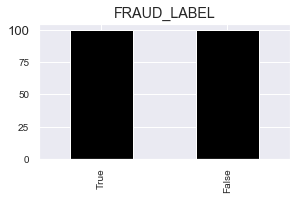

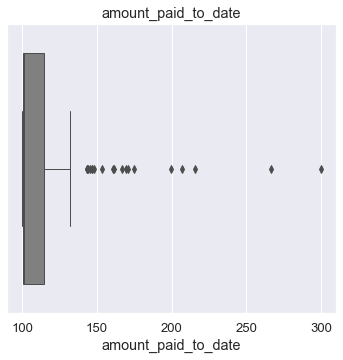

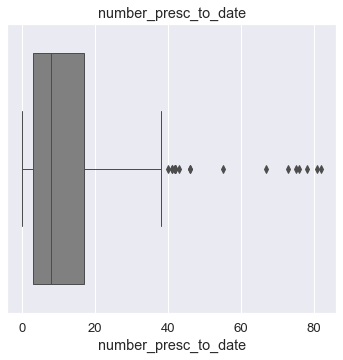

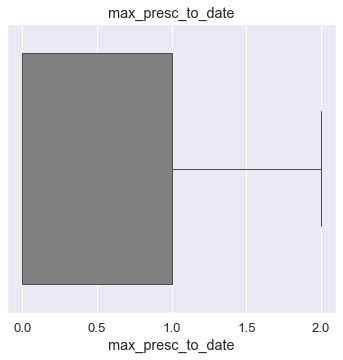

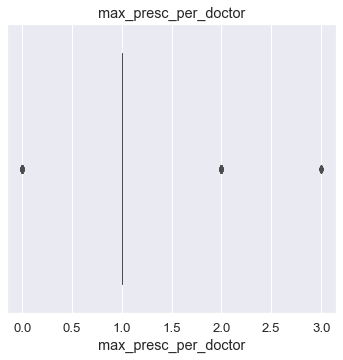

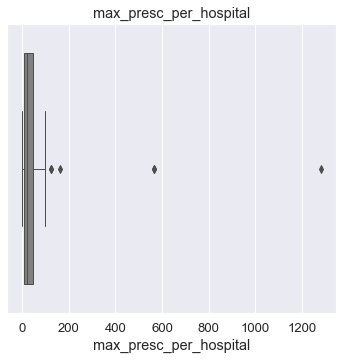

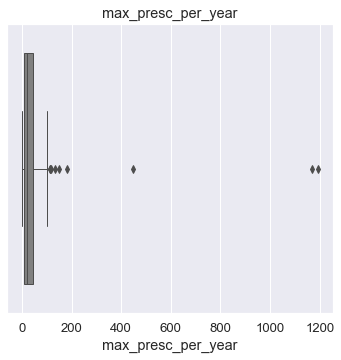

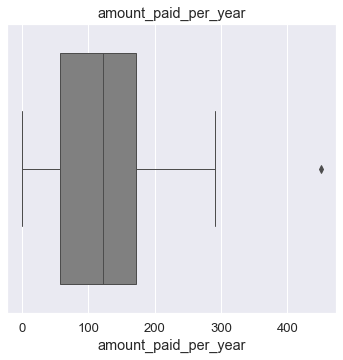

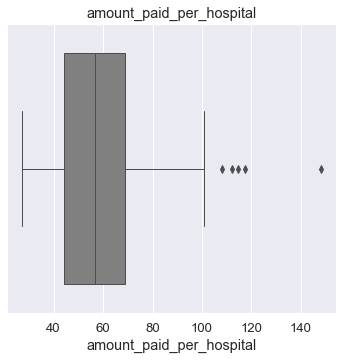

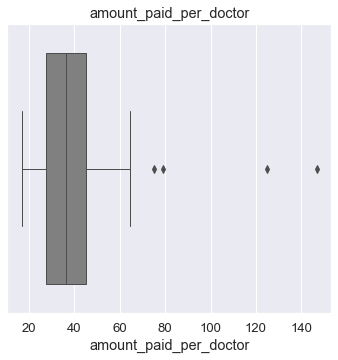

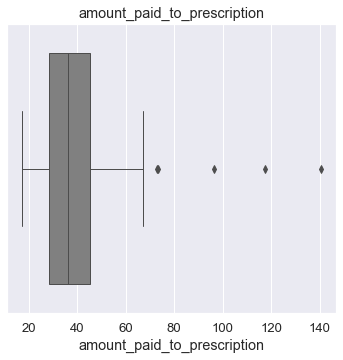

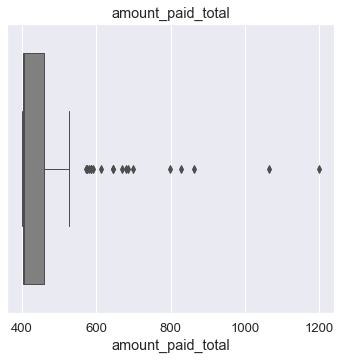

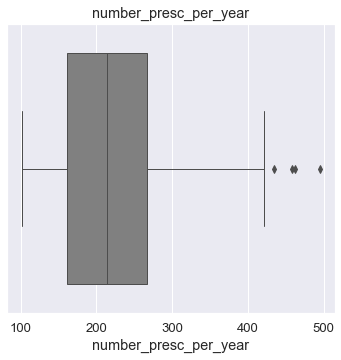

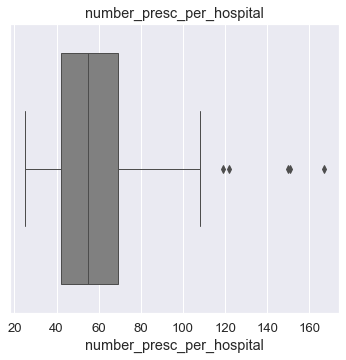

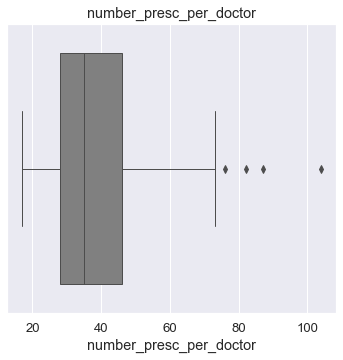

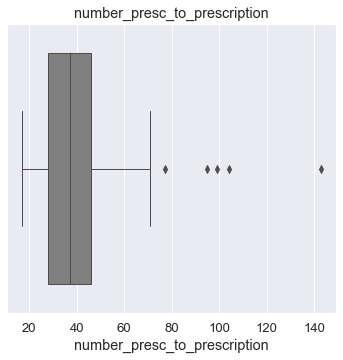

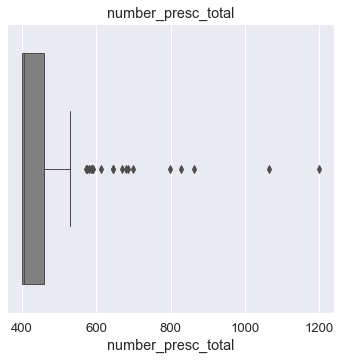

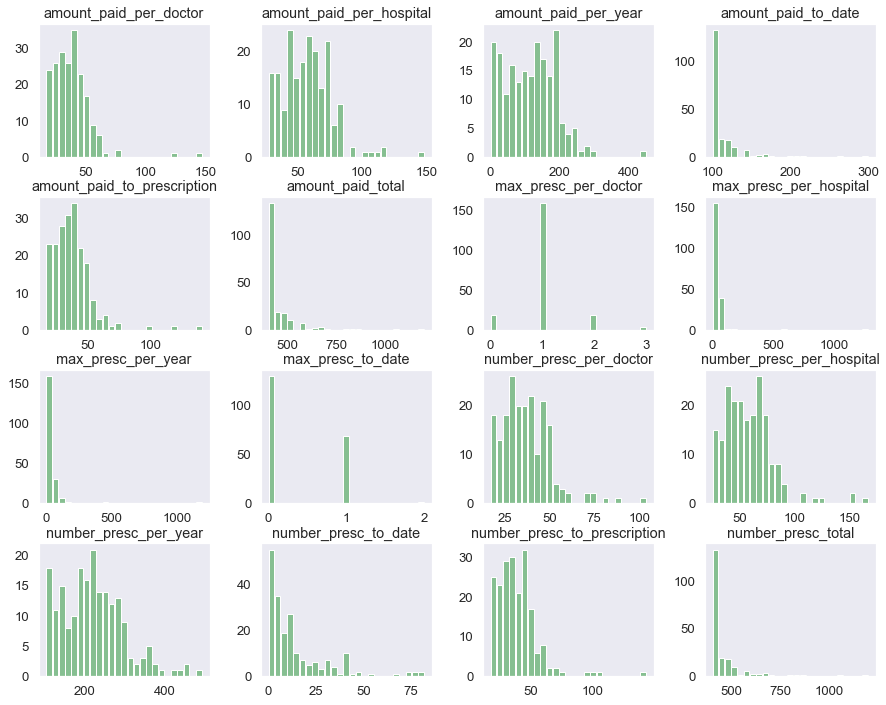

In [553]:

medical_df = load_data(FILE_NAME)
medical_df = cleaningup(medical_df, cols_to_delete=["id"])

basicanalysis(medical_df)
stringcolanalysis(medical_df)
numcolanalysis(medical_df)

stringcolencoding(medical_df)
medical_df = apply_label_encoding(medical_df, cols=[LABEL_COL])


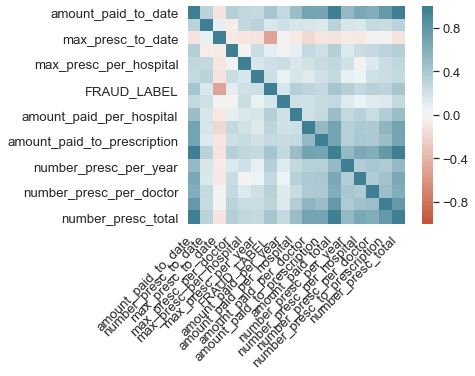

In [554]:
# Correlation Analysis
correlation_anlysis(medical_df)

Now lets run all supported ML alogrithms on complete dataset(selecting all features) using our helper functions and check results

In [558]:
# First run algorithms without cross validation
run_algorithms(medical_df, LABEL_COL, algo_list=get_supported_alogrithms())

print("------------------------------------")

# Now lets run same algorithms with cross validation
run_algorithms_cv(medical_df, LABEL_COL, algo_list=get_supported_alogrithms())

============ LogReg ===========
Prediction Vector: 
 [1 1 1 0 1 1 0 1 1 1 1 1 1 1 1 0 0 1 1 0 0 0 1 0 1 0 0 0 0 1 0 1 1 1 0 1 1
 1 1 0]
Accuracy: 
 80.0
Precision of event Happening: 
 76.0
Recall of event Happening: 
 90.47619047619048
AUC: 
 0.794486215538847
F-Score:
 0.8260869565217391
Confusion Matrix: 
 [[13  6]
 [ 2 19]]

============ KNN ===========
Prediction Vector: 
 [1 0 1 0 1 1 0 0 1 0 1 0 0 0 1 0 1 0 1 0 0 0 0 1 1 0 0 1 1 0 0 0 1 1 0 1 1
 1 1 0]
Accuracy: 
 70.0
Precision of event Happening: 
 73.68421052631578
Recall of event Happening: 
 66.66666666666666
AUC: 
 0.7017543859649122
F-Score:
 0.7
Confusion Matrix: 
 [[14  5]
 [ 7 14]]

============ GadientBoosting ===========
Prediction Vector: 
 [1 0 1 0 0 1 0 1 1 0 1 1 1 1 1 0 0 1 1 0 0 0 1 1 1 0 0 1 0 1 0 1 1 1 0 1 0
 1 1 0]
Accuracy: 
 95.0
Precision of event Happening: 
 91.30434782608695
Recall of event Happening: 
 100.0
AUC: 
 0.9473684210526316
F-Score:
 0.9545454545454545
Confusion Matrix: 
 [[17  2]
 [ 0 21]]



{'LogReg': {'accuracy': 73.5,
  'precision': 50.0,
  'recall': 35.5,
  'auc_val': nan,
  'f_score': 0.4084453558137769},
 'KNN': {'accuracy': 68.0,
  'precision': 50.0,
  'recall': 30.0,
  'auc_val': nan,
  'f_score': 0.35424170505840197},
 'GadientBoosting': {'accuracy': 81.5,
  'precision': 50.0,
  'recall': 38.0,
  'auc_val': nan,
  'f_score': 0.42439809536583734},
 'AdaBoost': {'accuracy': 78.0,
  'precision': 50.0,
  'recall': 40.0,
  'auc_val': nan,
  'f_score': 0.4414950664950664},
 'SVM': {'accuracy': 0.0,
  'precision': 0.0,
  'recall': 0.0,
  'auc_val': nan,
  'f_score': 0.0},
 'DecissionTree': {'accuracy': 82.5,
  'precision': 50.0,
  'recall': 38.5,
  'auc_val': nan,
  'f_score': 0.4302067485429116},
 'RandomForest': {'accuracy': 80.5,
  'precision': 50.0,
  'recall': 36.0,
  'auc_val': nan,
  'f_score': 0.4061214043065223},
 'NaiveBayes': {'accuracy': 77.0,
  'precision': 50.0,
  'recall': 29.0,
  'auc_val': nan,
  'f_score': 0.34367123981060643},
 'MultiLayerPerceptron': 

Now Lets experiment with RandomForest Feature Selection on our dataset

In [463]:
# Run all supported algorithms, with RandomForest Feature Seletion
MachineLearningwithRFFS(medical_df, LABEL_COL, threshold=5)

amount_paid_to_date             23.402710
number_presc_total              19.920915
amount_paid_total               16.796414
amount_paid_per_hospital         6.676776
max_presc_per_year               5.998432
max_presc_per_hospital           4.254546
number_presc_to_date             4.132039
number_presc_to_prescription     3.959885
max_presc_to_date                3.634316
number_presc_per_doctor          2.251408
amount_paid_per_year             2.105904
number_presc_per_year            1.919874
number_presc_per_hospital        1.755099
amount_paid_to_prescription      1.721645
amount_paid_per_doctor           1.146783
max_presc_per_doctor             0.323254
dtype: float64
Selected Features =['amount_paid_to_date', 'number_presc_total', 'amount_paid_total', 'amount_paid_per_hospital', 'max_presc_per_year', 'FRAUD_LABEL']


 Results for LogReg.....
Prediction Vector: 
 [1 0 0 0 1 1 0 0 1 0 1 0 1 0 1 0 0 1 1 1 0 0 0 0 1 0 0 1 1 1 0 0 1 1 0 1 0
 1 1 0]
Accuracy: 
 80.0
Precision of e

Lets try the same with Mutual Information Feature Seletion, we can try different threshold values as well

In [559]:
# Run all supported algorithms, with Mutual Information Feature Seletion
MachineLearningwithMIFS(medical_df, LABEL_COL, threshold=6)

amount_paid_total               39.201952
amount_paid_to_date             39.201952
number_presc_total              38.932311
max_presc_per_hospital          22.436704
max_presc_per_year              20.244113
number_presc_to_date            17.565664
amount_paid_per_hospital        16.158517
max_presc_to_date               14.192018
number_presc_per_hospital        9.944469
number_presc_per_year            8.497845
number_presc_to_prescription     7.506607
number_presc_per_doctor          5.437904
amount_paid_per_year             5.159686
amount_paid_per_doctor           5.031914
amount_paid_to_prescription      2.432750
max_presc_per_doctor             0.236318
dtype: float64
Selected Features =['amount_paid_total', 'amount_paid_to_date', 'number_presc_total', 'max_presc_per_hospital', 'max_presc_per_year', 'number_presc_to_date', 'amount_paid_per_hospital', 'max_presc_to_date', 'number_presc_per_hospital', 'number_presc_per_year', 'number_presc_to_prescription', 'FRAUD_LABEL']


 Re

Now Lets try out our recursive elimination features selection methods.

We have implemented a Generic method, lets try it with `LogisticRegression` for recursive elimination feature selection and use `LogReg, KNN` for training models on selected features, here is the example usage

In [562]:

# Note: solver and penalty are the arguments for LogisticRegression
GenericREFS(medical_df, LABEL_COL,
            algo_list=[LogReg, KNN],
            re_algo=LogisticRegression,
            solver='liblinear',penalty='l2')

============ LogReg ===========
Prediction Vector: 
 [1 0 1 0 1 1 0 1 1 1 1 1 1 1 1 0 0 1 1 0 0 0 1 0 1 0 0 0 0 1 0 1 1 1 0 1 1
 1 1 0]
Accuracy: 
 82.5
Precision of event Happening: 
 79.16666666666666
Recall of event Happening: 
 90.47619047619048
AUC: 
 0.8208020050125314
F-Score:
 0.8444444444444444
Confusion Matrix: 
 [[14  5]
 [ 2 19]]

============ KNN ===========
Prediction Vector: 
 [1 0 1 0 1 1 0 0 1 0 1 1 0 1 1 0 0 1 1 0 0 0 1 1 1 1 0 1 0 1 0 0 1 1 0 1 0
 1 1 0]
Accuracy: 
 87.5
Precision of event Happening: 
 86.36363636363636
Recall of event Happening: 
 90.47619047619048
AUC: 
 0.8734335839598997
F-Score:
 0.8837209302325582
Confusion Matrix: 
 [[16  3]
 [ 2 19]]



Now lets try out the same with RandomForestClassifier for recursive elimination feature selection

In [563]:

# Note: n_estimator and random_state are the arguments for RandomForestClassifier
GenericREFS(medical_df, LABEL_COL,
            algo_list=[LogReg, KNN],
            re_algo=RandomForestClassifier,
            n_estimators=10, random_state=91)

============ LogReg ===========
Prediction Vector: 
 [1 0 1 0 1 1 0 0 1 0 1 0 1 0 1 0 0 1 1 0 0 0 0 0 1 0 0 1 0 0 0 1 1 1 0 1 0
 1 1 0]
Accuracy: 
 77.5
Precision of event Happening: 
 83.33333333333334
Recall of event Happening: 
 71.42857142857143
AUC: 
 0.7781954887218044
F-Score:
 0.7692307692307692
Confusion Matrix: 
 [[16  3]
 [ 6 15]]

============ KNN ===========
Prediction Vector: 
 [1 0 1 0 1 1 0 1 1 0 1 1 1 1 1 0 0 1 1 0 0 0 0 1 1 0 0 1 0 1 0 1 1 1 0 1 1
 1 1 0]
Accuracy: 
 87.5
Precision of event Happening: 
 83.33333333333334
Recall of event Happening: 
 95.23809523809523
AUC: 
 0.8709273182957393
F-Score:
 0.888888888888889
Confusion Matrix: 
 [[15  4]
 [ 1 20]]



We have also implemented Generic method for recursive elimination feature selection, lets try that as well.
Again we can use any alogrithm for recursive elimination feature selection and any model for training models on selected features

In [564]:
# Here we are using LogisticRegression for feature selection,
# solver and penalty are the parameters for LogisticRegression.
# and we are training models with LogReg, KNN, RandomForest and SVM

GenericREFS_CV(medical_df, LABEL_COL,
                algo_list=[LogReg, KNN, RandomForest, SVM],
                re_algo=LogisticRegression,
                solver='liblinear',penalty='l2')

============ LogReg ===========
{'accuracy': 76.5, 'precision': 50.0, 'recall': 39.5, 'auc_val': nan, 'f_score': 0.43774365607981913}

============ KNN ===========
{'accuracy': 76.0, 'precision': 50.0, 'recall': 38.0, 'auc_val': nan, 'f_score': 0.42339375184202777}

============ RandomForest ===========
{'accuracy': 82.5, 'precision': 50.0, 'recall': 38.5, 'auc_val': nan, 'f_score': 0.42724304557920856}

============ SVM ===========
{'accuracy': 67.5, 'precision': 50.0, 'recall': 48.5, 'auc_val': nan, 'f_score': 0.49230769230769234}

